In [ ]:
import pandas as pd
import math

df = pd.read_csv('/content/ProphetLargeBufferDMR.txt', sep=' ', header = None)
df = df.loc[1:,[0, 6,7,10]]
df = df.rename(columns = {0: 'Time', 6: 'Source', 7: 'Dest', 10: 'Path'})
#filtered_df.to_csv('filtered_dtn_report_data.csv', index=False)
df

In [ ]:
df_n = pd.DataFrame({'epoch': [], 'source': [], 'dest':[], 'current':[], 'next_hop': []})

for index, row in df.iterrows():
    path_nodes = row['Path'].split("->")
    for i_p in range(0,len(path_nodes)-1):
      df_n = df_n.append({'epoch': float(row['Time']), 'source': int(row['Source'][1:]), 'dest': int(row['Dest'][1:]), \
                          'current' : int(path_nodes[i_p][1:]), 'next_hop': int(path_nodes[i_p + 1][1:])}, ignore_index = True)
      #df.loc[index,p] = 1

#del df['Path']
df_n['epoch'] = df_n['epoch'] / 60000
df_n['epoch'] = df_n['epoch'].apply(lambda x:  math.floor(x))
df_n.to_csv('training_data_router_nn.csv')


In [ ]:
df_n

In [ ]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.metrics import f1_score
import math


data = pd.read_csv('/content/training_data_router_nn.csv')
label_encoder_source = LabelEncoder()
label_encoder_dest = LabelEncoder()
label_encoder_current = LabelEncoder()
label_encoder_next = LabelEncoder()
label_encoder_epoch = LabelEncoder()

#data['source'] = label_encoder_source.fit_transform(data['source'])
#data['dest'] = label_encoder_dest.fit_transform(data['dest'])
#data['current'] = label_encoder_current.fit_transform(data['current'])
#data['next_hop'] = label_encoder_next.fit_transform(data['next_hop'])
#data['epoch'] = label_encoder_epoch.fit_transform(data['epoch'])

X = data[['epoch', 'source', 'dest', 'current']].values
Y = data[['next_hop']].values

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

class ReportDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = ReportDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=1094, shuffle=False)

class ACNet(nn.Module):
    def __init__(self):
        super(ACNet, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(4096, 256)
        self.fc5 = nn.Linear(128, 6)
        self.fc6 = nn.Linear(6, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        #x = F.relu(self.fc6(x))
        x = self.fc6(x)
        return x

# NN, Loss Function, and Optimizer
net = ACNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# Training Loop
num_epochs = 90000
net.train()
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.float(), labels.float()
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = net(inputs)

        # Compute loss
        y = (labels.long()).squeeze().view(-1, 1)
        loss = criterion(y_pred.float(), y.float())
        print(float(loss.detach()))
        losses.append(float(loss.detach()))
        if(float(loss.detach()) < 150):
          break

        #print(num_matches)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

print('Finished Training')


In [14]:
print(y)
print(y_pred)

tensor([[ 98],
        [ 13],
        [  0],
        ...,
        [126],
        [114],
        [150]])
tensor([[103.3182],
        [ 13.2705],
        [  0.2741],
        ...,
        [128.0601],
        [115.9292],
        [151.7544]], grad_fn=<AddmmBackward0>)


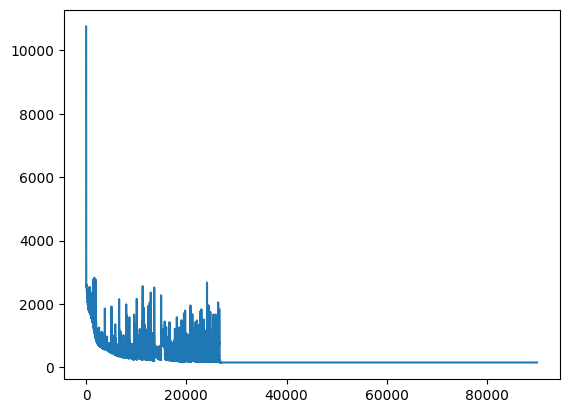

In [15]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [16]:
m = torch.jit.script(net)
torch.jit.save(m, 'scriptmodule3.pt')


In [12]:
model = torch.jit.load('/content/scriptmodule2.pt')

# Prepare the input data
input_data = [3, 101, 150, 101]
input_tensor = torch.tensor(input_data, dtype=torch.float32).view(1, -1)

# Run the model
with torch.no_grad():
    output = model(input_tensor)

# Output
output

tensor([[92.0010]])